# Integrated Multi-Dataset Deepfake Detection Training

## Overview
This notebook implements **integrated training** across multiple deepfake detection datasets using the **Complete Attention Model**.

### Datasets Integrated:
1. **FaceForensics++**: Multiple manipulation methods (Deepfakes, Face2Face, FaceSwap, etc.)
2. **Celeb-DF**: Celebrity deepfake dataset with high-quality fakes
3. **Deepfake Detection Challenge (DFDC)**: Kaggle competition dataset
4. **HiDF**: High-fidelity deepfake dataset (videos and images)

### Key Features:
- Configurable data percentage (default: 5%)
- Complete Attention Model architecture
- Multi-domain feature extraction (Spatial, Frequency, Semantic)
- Cross-dataset performance analysis

---

## Section 1: Setup & Configuration

In [1]:
# ============================================================================
# IMPORTS
# ============================================================================

import os
import json
import numpy as np
import pandas as pd
import random
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Image processing
import cv2
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms

# Models
import timm
from facenet_pytorch import MTCNN

# Analysis and visualization
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

# Set random seeds for reproducibility
def set_seed(seed=42):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# # Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(f"{'='*70}")
print("ENVIRONMENT SETUP")
print(f"{'='*70}")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("⚠ Running on CPU - training will be slower")
print(f"PyTorch Version: {torch.__version__}")
print(f"{'='*70}")

ENVIRONMENT SETUP
Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA Version: 11.8
GPU Memory: 6.00 GB
PyTorch Version: 2.7.1+cu118


In [2]:
# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Central configuration for the integrated training pipeline."""
    
    # ==========================================================================
    # DATA PERCENTAGE - Controls how much data to use from each dataset
    # ==========================================================================
    # Global default (used if per-dataset value not specified)
    # DATA_PERCENTAGE = 0.01  # 1% default
    
    # Per-dataset percentages (0.01 to 1.0)
    FFPP_PERCENTAGE = 0.1       # FaceForensics++ percentage
    CELEBDF_PERCENTAGE = 0.05  # Celeb-DF percentage
    DFDC_PERCENTAGE = 0.3      # DFDC percentage
    HIDF_PERCENTAGE = 0.5      # HiDF percentage
    
    # ==========================================================================
    # Dataset Paths
    # ==========================================================================
    BASE_DIR = Path('E:/MMF Deepfake Detection')
    DATASETS_DIR = BASE_DIR / 'datasets'
    
    # Individual dataset paths
    FFPP_DIR = DATASETS_DIR / 'FaceForensics++'
    CELEBDF_DIR = DATASETS_DIR / 'CelebDF'
    DFDC_DIR = DATASETS_DIR / 'deepfake-detection-challenge'
    HIDF_DIR = DATASETS_DIR / 'HiDF'
    
    # Output directories
    PREPROCESSED_DIR = BASE_DIR / 'preprocessed_faces_integrated'
    FEATURES_DIR = BASE_DIR / 'extracted_features_integrated'
    CHECKPOINTS_DIR = BASE_DIR / 'checkpoints'
    RESULTS_DIR = BASE_DIR / 'results'
    INTEGRATED_METADATA_PATH = BASE_DIR / 'integrated_metadata.csv'
    
    # Data settings
    FRAMES_PER_VIDEO = 20
    FACE_SIZE = 299
    TRAIN_RATIO = 0.8
    
    # Feature dimensions
    SPATIAL_DIM = 2048   # Xception output
    FREQ_DIM = 4         # FFT statistical features
    SEMANTIC_DIM = 768   # DINOv2 ViT-B/14 output
    
    # Training settings
    BATCH_SIZE = 128
    LEARNING_RATE = 1e-4
    EPOCHS = 20
    HIDDEN_DIM1 = 512
    HIDDEN_DIM2 = 256
    DROPOUT = 0.5
    FUSION_DIM = 512
    
    # Early stopping
    PATIENCE = 5
    MIN_DELTA = 0.001

config = Config()

# Create directory structure
def create_directories():
    """Create all necessary directories."""
    dirs = [
        config.PREPROCESSED_DIR / 'real',
        config.PREPROCESSED_DIR / 'fake',
        config.FEATURES_DIR / 'spatial',
        config.FEATURES_DIR / 'frequency',
        config.FEATURES_DIR / 'semantic',
        config.CHECKPOINTS_DIR,
        config.RESULTS_DIR
    ]
    for dir_path in dirs:
        dir_path.mkdir(parents=True, exist_ok=True)
    print("✓ Directory structure created")

create_directories()

# Display configuration
print(f"\n{'='*70}")
print("PROJECT CONFIGURATION")
print(f"{'='*70}")
print(f"Data Percentages:")
print(f"  - FaceForensics++: {config.FFPP_PERCENTAGE * 100:.1f}%")
print(f"  - Celeb-DF: {config.CELEBDF_PERCENTAGE * 100:.1f}%")
print(f"  - DFDC: {config.DFDC_PERCENTAGE * 100:.1f}%")
print(f"  - HiDF: {config.HIDF_PERCENTAGE * 100:.1f}%")
print(f"Base Directory: {config.BASE_DIR.absolute()}")
print(f"Frames per video: {config.FRAMES_PER_VIDEO}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Learning rate: {config.LEARNING_RATE}")
print(f"Epochs: {config.EPOCHS}")
print(f"Feature dimensions: Spatial={config.SPATIAL_DIM}, Freq={config.FREQ_DIM}, Semantic={config.SEMANTIC_DIM}")
print(f"{'='*70}")

✓ Directory structure created

PROJECT CONFIGURATION
Data Percentages:
  - FaceForensics++: 10.0%
  - Celeb-DF: 5.0%
  - DFDC: 30.0%
  - HiDF: 50.0%
Base Directory: E:\MMF Deepfake Detection
Frames per video: 20
Batch size: 128
Learning rate: 0.0001
Epochs: 20
Feature dimensions: Spatial=2048, Freq=4, Semantic=768


## Section 2: Dataset Loaders

Load and parse metadata from all four datasets.

In [3]:
# ============================================================================
# FACEFORENSICS++ DATASET LOADER
# ============================================================================

def load_ffpp_dataset(data_percentage=None):
    """
    Load FaceForensics++ dataset metadata.
    Uses CSV files from datasets/FaceForensics++/csv/
    
    Returns:
        DataFrame with columns: video_id, label, path, manipulation, dataset
    """
    # Use FFPP-specific percentage, or fallback to provided/global
    data_percentage = data_percentage or config.FFPP_PERCENTAGE
    csv_dir = config.FFPP_DIR / 'csv'
    
    if not csv_dir.exists():
        print(f"⚠ FaceForensics++ CSV directory not found: {csv_dir}")
        return pd.DataFrame()
    
    data = []
    
    # Load original (real) videos
    original_csv = csv_dir / 'original.csv'
    if original_csv.exists():
        df_orig = pd.read_csv(original_csv)
        # Sample the required percentage
        n_samples = max(1, int(len(df_orig) * data_percentage))
        df_orig_sampled = df_orig.sample(n=n_samples, random_state=42)
        
        for _, row in df_orig_sampled.iterrows():
            file_path = row['File Path']
            video_name = Path(file_path).stem
            full_path = config.FFPP_DIR / file_path
            if full_path.exists():
                data.append({
                    'video_id': f'FFPP_original_{video_name}',
                    'label': 'real',
                    'path': str(full_path),
                    'manipulation': 'Original',
                    'dataset': 'FaceForensics++'
                })
    
    # Load fake videos from different manipulation methods
    manipulation_csvs = ['Deepfakes.csv', 'Face2Face.csv', 'FaceSwap.csv', 
                         'NeuralTextures.csv', 'FaceShifter.csv']
    
    for csv_name in manipulation_csvs:
        csv_path = csv_dir / csv_name
        if csv_path.exists():
            df = pd.read_csv(csv_path)
            manipulation = csv_name.replace('.csv', '')
            
            # Sample the required percentage
            n_samples = max(1, int(len(df) * data_percentage))
            df_sampled = df.sample(n=n_samples, random_state=42)
            
            for _, row in df_sampled.iterrows():
                file_path = row['File Path']
                video_name = Path(file_path).stem
                full_path = config.FFPP_DIR / file_path
                if full_path.exists():
                    data.append({
                        'video_id': f'FFPP_{manipulation}_{video_name}',
                        'label': 'fake',
                        'path': str(full_path),
                        'manipulation': manipulation,
                        'dataset': 'FaceForensics++'
                    })
    
    # Also check FF++_Metadata.csv for DeepFakeDetection videos
    metadata_csv = csv_dir / 'FF++_Metadata.csv'
    if metadata_csv.exists():
        df_meta = pd.read_csv(metadata_csv)
        # Filter for DeepFakeDetection
        df_dfd = df_meta[df_meta['File Path'].str.contains('DeepFakeDetection', na=False)]
        
        n_samples = max(1, int(len(df_dfd) * data_percentage))
        df_dfd_sampled = df_dfd.sample(n=min(n_samples, len(df_dfd)), random_state=42)
        
        for _, row in df_dfd_sampled.iterrows():
            file_path = row['File Path']
            video_name = Path(file_path).stem
            full_path = config.FFPP_DIR / file_path
            label = 'fake' if row['Label'] == 'FAKE' else 'real'
            if full_path.exists():
                data.append({
                    'video_id': f'FFPP_DeepFakeDetection_{video_name}',
                    'label': label,
                    'path': str(full_path),
                    'manipulation': 'DeepFakeDetection',
                    'dataset': 'FaceForensics++'
                })
    
    df_result = pd.DataFrame(data)
    print(f"✓ FaceForensics++: Loaded {len(df_result)} videos ({data_percentage*100:.1f}%)")
    if len(df_result) > 0:
        print(f"  Real: {len(df_result[df_result['label'] == 'real'])}, Fake: {len(df_result[df_result['label'] == 'fake'])}")
    
    return df_result

In [4]:
# ============================================================================
# CELEB-DF DATASET LOADER
# ============================================================================

def load_celebdf_dataset(data_percentage=None):
    """
    Load Celeb-DF dataset metadata.
    Uses List_of_testing_videos.txt for ground truth labels.
    
    Format: <label> <path>
    - Label 1 = Real
    - Label 0 = Fake (Celeb-synthesis)
    
    Returns:
        DataFrame with columns: video_id, label, path, manipulation, dataset
    """
    # Use Celeb-DF-specific percentage, or fallback to provided/global
    data_percentage = data_percentage or config.CELEBDF_PERCENTAGE
    list_file = config.CELEBDF_DIR / 'List_of_testing_videos.txt'
    
    if not list_file.exists():
        print(f"⚠ Celeb-DF list file not found: {list_file}")
        return pd.DataFrame()
    
    data = []
    
    with open(list_file, 'r') as f:
        lines = f.readlines()
    
    # Parse all entries
    all_entries = []
    for line in lines:
        line = line.strip()
        if not line:
            continue
        parts = line.split()
        if len(parts) >= 2:
            file_label = int(parts[0])
            file_path = parts[1]
            all_entries.append((file_label, file_path))
    
    # Sample the required percentage
    n_samples = max(1, int(len(all_entries) * data_percentage))
    random.seed(42)
    sampled_entries = random.sample(all_entries, min(n_samples, len(all_entries)))
    
    for file_label, file_path in sampled_entries:
        video_name = Path(file_path).stem
        folder_name = Path(file_path).parent.name
        full_path = config.CELEBDF_DIR / file_path
        
        # Label 1 = Real, Label 0 = Fake
        label = 'real' if file_label == 1 else 'fake'
        
        # Determine manipulation type based on folder
        if 'synthesis' in folder_name.lower():
            manipulation = 'Celeb-synthesis'
        elif 'real' in folder_name.lower():
            manipulation = 'Original'
        else:
            manipulation = folder_name
        
        if full_path.exists():
            data.append({
                'video_id': f'CelebDF_{folder_name}_{video_name}',
                'label': label,
                'path': str(full_path),
                'manipulation': manipulation,
                'dataset': 'Celeb-DF'
            })
    
    df_result = pd.DataFrame(data)
    print(f"✓ Celeb-DF: Loaded {len(df_result)} videos ({data_percentage*100:.1f}%)")
    if len(df_result) > 0:
        print(f"  Real: {len(df_result[df_result['label'] == 'real'])}, Fake: {len(df_result[df_result['label'] == 'fake'])}")
    
    return df_result

In [5]:
# ============================================================================
# DFDC (DEEPFAKE DETECTION CHALLENGE) DATASET LOADER
# ============================================================================

def load_dfdc_dataset(data_percentage=None):
    """
    Load DFDC dataset metadata.
    Uses metadata.json from train_sample_videos directory.
    
    Format: {"filename.mp4": {"label": "REAL"/"FAKE", "split": "train", "original": ...}}
    
    Returns:
        DataFrame with columns: video_id, label, path, manipulation, dataset
    """
    # Use DFDC-specific percentage, or fallback to provided/global
    data_percentage = data_percentage or config.DFDC_PERCENTAGE
    videos_dir = config.DFDC_DIR / 'train_sample_videos'
    metadata_file = videos_dir / 'metadata.json'
    
    if not metadata_file.exists():
        print(f"⚠ DFDC metadata file not found: {metadata_file}")
        return pd.DataFrame()
    
    data = []
    
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
    
    # Get all entries
    all_entries = list(metadata.items())
    
    # Sample the required percentage
    n_samples = max(1, int(len(all_entries) * data_percentage))
    random.seed(42)
    sampled_entries = random.sample(all_entries, min(n_samples, len(all_entries)))
    
    for filename, info in sampled_entries:
        video_path = videos_dir / filename
        video_name = Path(filename).stem
        label = 'real' if info['label'] == 'REAL' else 'fake'
        
        # Determine manipulation type
        if label == 'fake':
            manipulation = 'DFDC_DeepFake'
        else:
            manipulation = 'Original'
        
        if video_path.exists():
            data.append({
                'video_id': f'DFDC_{video_name}',
                'label': label,
                'path': str(video_path),
                'manipulation': manipulation,
                'dataset': 'DFDC'
            })
    
    df_result = pd.DataFrame(data)
    print(f"✓ DFDC: Loaded {len(df_result)} videos ({data_percentage*100:.1f}%)")
    if len(df_result) > 0:
        print(f"  Real: {len(df_result[df_result['label'] == 'real'])}, Fake: {len(df_result[df_result['label'] == 'fake'])}")
    
    return df_result

In [6]:
# ============================================================================
# HiDF DATASET LOADER
# ============================================================================

def load_hidf_dataset(data_percentage=None):
    """
    Load HiDF dataset metadata using FOLDER-BASED LABELING.
    
    Labeling based on folder names:
    - Files in Fake-vid, Fake-img folders → label = "fake"
    - Files in Real-vid, Real-img folders → label = "real"
    
    This approach directly scans the folders instead of relying on metadata.csv,
    which ensures accurate labeling based on actual file locations.
    
    Directories:
    - Real-vid: Real videos (.mp4)
    - Real-img: Real images (.jpg, .png) - may not exist yet
    - Fake-vid: Fake videos (.mp4)
    - Fake-img: Fake images (.jpg, .png)
    
    Returns:
        DataFrame with columns: video_id, label, path, manipulation, dataset, media_type
    """
    # Use HiDF-specific percentage, or fallback to provided/global
    data_percentage = data_percentage or config.HIDF_PERCENTAGE
    
    data = []
    
    # Define folder configurations: (folder_name, label, media_type, manipulation)
    folder_configs = [
        ('Fake-vid', 'fake', 'vid', 'HiDF_FaceSwap'),
        ('Fake-img', 'fake', 'img', 'HiDF_FaceSwap'),
        ('Real-vid', 'real', 'vid', 'Original'),
        ('Real-img', 'real', 'img', 'Original'),
    ]
    
    for folder_name, label, media_type, manipulation in folder_configs:
        folder_path = config.HIDF_DIR / folder_name
        
        if not folder_path.exists():
            print(f"  ⚠ HiDF folder not found: {folder_name}")
            continue
        
        # Define file extensions based on media type
        if media_type == 'vid':
            extensions = ['*.mp4', '*.avi', '*.mov', '*.mkv']
        else:
            extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
        
        # Collect all files from this folder
        all_files = []
        for ext in extensions:
            all_files.extend(list(folder_path.glob(ext)))
        
        if not all_files:
            print(f"  ⚠ No files found in {folder_name}")
            continue
        
        # Sample the required percentage
        n_samples = max(1, int(len(all_files) * data_percentage))
        random.seed(42)
        sampled_files = random.sample(all_files, min(n_samples, len(all_files)))
        
        # Add sampled files to data
        for file_path in sampled_files:
            file_name = file_path.stem.strip()
            data.append({
                'video_id': f'HiDF_{label}_{folder_name}_{file_name}',
                'label': label,
                'path': str(file_path),
                'manipulation': manipulation,
                'dataset': 'HiDF',
                'media_type': media_type
            })
    
    df_result = pd.DataFrame(data)
    print(f"✓ HiDF: Loaded {len(df_result)} items ({data_percentage*100:.1f}%)")
    if len(df_result) > 0:
        print(f"  Real: {len(df_result[df_result['label'] == 'real'])}, Fake: {len(df_result[df_result['label'] == 'fake'])}")
        if 'media_type' in df_result.columns:
            vid_count = len(df_result[df_result['media_type'] == 'vid'])
            img_count = len(df_result[df_result['media_type'] == 'img'])
            print(f"  Videos: {vid_count}, Images: {img_count}")
    
    return df_result

In [7]:
# ============================================================================
# LOAD AND COMBINE ALL DATASETS
# ============================================================================

def load_all_datasets():
    """
    Load and combine all four datasets.
    Each dataset uses its own percentage from Config.
    
    Returns:
        DataFrame with combined metadata from all datasets
    """
    print(f"\n{'='*70}")
    print("LOADING DATASETS (per-dataset percentages)")
    print(f"{'='*70}")
    
    # Load each dataset (each uses its own config percentage)
    df_ffpp = load_ffpp_dataset()
    df_celebdf = load_celebdf_dataset()
    df_dfdc = load_dfdc_dataset()
    df_hidf = load_hidf_dataset()
    
    # Combine all datasets
    all_dfs = [df for df in [df_ffpp, df_celebdf, df_dfdc, df_hidf] if len(df) > 0]
    
    if not all_dfs:
        print("⚠ No datasets loaded!")
        return pd.DataFrame()
    
    combined_df = pd.concat(all_dfs, ignore_index=True)
    
    # Remove duplicates based on path
    combined_df = combined_df.drop_duplicates(subset=['path'])
    
    print(f"\n{'='*70}")
    print("COMBINED DATASET STATISTICS")
    print(f"{'='*70}")
    print(f"Total samples: {len(combined_df)}")
    print(f"Real: {len(combined_df[combined_df['label'] == 'real'])}, Fake: {len(combined_df[combined_df['label'] == 'fake'])}")
    print(f"\nSamples per dataset:")
    print(combined_df['dataset'].value_counts())
    print(f"\nManipulation types:")
    print(combined_df['manipulation'].value_counts())
    
    # Save combined metadata
    combined_df.to_csv(config.INTEGRATED_METADATA_PATH, index=False)
    print(f"\n✓ Metadata saved to: {config.INTEGRATED_METADATA_PATH}")
    
    return combined_df

# Load all datasets
integrated_metadata = load_all_datasets()


LOADING DATASETS (per-dataset percentages)
✓ FaceForensics++: Loaded 700 videos (10.0%)
  Real: 100, Fake: 600
✓ Celeb-DF: Loaded 25 videos (5.0%)
  Real: 12, Fake: 13
✓ DFDC: Loaded 120 videos (30.0%)
  Real: 19, Fake: 101
  ⚠ HiDF folder not found: Real-img
✓ HiDF: Loaded 19984 items (50.0%)
  Real: 2180, Fake: 17804
  Videos: 4360, Images: 15624

COMBINED DATASET STATISTICS
Total samples: 20829
Real: 2311, Fake: 18518

Samples per dataset:
dataset
HiDF               19984
FaceForensics++      700
DFDC                 120
Celeb-DF              25
Name: count, dtype: int64

Manipulation types:
manipulation
HiDF_FaceSwap        17804
Original              2311
DFDC_DeepFake          101
Deepfakes              100
Face2Face              100
FaceSwap               100
FaceShifter            100
NeuralTextures         100
DeepFakeDetection      100
Celeb-synthesis         13
Name: count, dtype: int64

✓ Metadata saved to: E:\MMF Deepfake Detection\integrated_metadata.csv


## Section 3: Face Detection & Extraction

In [8]:
# ============================================================================
# FACE EXTRACTION (skips already-processed items automatically)
# ============================================================================

def extract_faces_integrated(metadata_df, output_dir, frames_per_video=20, image_size=299):
    """
    Extract faces from videos/images using MTCNN.
    Handles both video and image inputs.
    AUTOMATICALLY SKIPS already-processed items based on output directory existence.
    
    Args:
        metadata_df: DataFrame with video/image metadata
        output_dir: Directory to save extracted faces
        frames_per_video: Number of frames to sample from videos
        image_size: Output face image size
    """
    print(f"\n{'='*70}")
    print("FACE EXTRACTION WITH MTCNN")
    print(f"{'='*70}")
    
    # Initialize MTCNN
    mtcnn = MTCNN(
        image_size=image_size,
        margin=40,
        min_face_size=20,
        thresholds=[0.6, 0.7, 0.7],
        factor=0.709,
        post_process=True,
        keep_all=False,
        device=device
    )
    
    processed = 0
    skipped = 0
    errors = 0
    
    for idx, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="Extracting faces"):
        file_path = row['path']
        video_id = row['video_id']
        label = row['label']
        media_type = row.get('media_type', 'vid')  # Default to video
        
        # Determine media type from file extension if not specified
        ext = Path(file_path).suffix.lower()
        if ext in ['.jpg', '.jpeg', '.png', '.bmp']:
            media_type = 'img'
        elif ext in ['.mp4', '.avi', '.mov', '.mkv']:
            media_type = 'vid'
        
        # Sanitize video_id: strip whitespace to avoid Windows path errors
        video_id = str(video_id).strip()
        video_output_dir = output_dir / label / video_id
        
        # Skip if already processed (key logic for re-runs)
        if video_output_dir.exists():
            existing_files = list(video_output_dir.glob('*.png'))
            min_expected = 1 if media_type == 'img' else max(1, frames_per_video // 4)
            if len(existing_files) >= min_expected:
                skipped += 1
                continue
        
        video_output_dir.mkdir(parents=True, exist_ok=True)
        
        try:
            if media_type == 'img':
                # Handle image
                img = cv2.imread(file_path)
                if img is None:
                    errors += 1
                    continue
                
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                face = mtcnn(img_rgb)
                
                if face is not None:
                    save_path = video_output_dir / 'frame_0.png'
                    face_np = (face.permute(1, 2, 0).cpu().numpy() * 255.0).clip(0, 255).astype('uint8')
                    face_bgr = cv2.cvtColor(face_np, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(str(save_path), face_bgr)
                    processed += 1
                else:
                    errors += 1
                    
            else:
                # Handle video
                cap = cv2.VideoCapture(str(file_path))
                total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                
                if total_frames == 0:
                    errors += 1
                    cap.release()
                    continue
                
                frame_indices = torch.linspace(0, total_frames - 1, frames_per_video).long()
                saved_count = 0
                
                for frame_idx in frame_indices:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx.item())
                    ret, frame = cap.read()
                    
                    if not ret:
                        continue
                    
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    face = mtcnn(frame_rgb)
                    
                    if face is not None:
                        save_path = video_output_dir / f'frame_{saved_count}.png'
                        face_np = (face.permute(1, 2, 0).cpu().numpy() * 255.0).clip(0, 255).astype('uint8')
                        face_bgr = cv2.cvtColor(face_np, cv2.COLOR_RGB2BGR)
                        cv2.imwrite(str(save_path), face_bgr)
                        saved_count += 1
                    
                    if saved_count >= frames_per_video:
                        break
                
                cap.release()
                processed += 1
                
        except Exception as e:
            errors += 1
    
    print(f"\n{'='*70}")
    print(f"Face extraction complete!")
    print(f"Processed: {processed}, Skipped (already done): {skipped}, Errors: {errors}")
    print(f"{'='*70}")

# Run face extraction
extract_faces_integrated(
    integrated_metadata, 
    config.PREPROCESSED_DIR,
    config.FRAMES_PER_VIDEO, 

    config.FACE_SIZE)


FACE EXTRACTION WITH MTCNN


Extracting faces: 100%|██████████| 20829/20829 [00:34<00:00, 602.17it/s] 


Face extraction complete!
Processed: 14, Skipped (already done): 20812, Errors: 3


## Section 4: Feature Extractors

In [9]:
# ============================================================================
# FEATURE EXTRACTORS
# ============================================================================

class SpatialExtractor(nn.Module):
    """XceptionNet-based spatial feature extractor (2048-dim)."""
    
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('xception', pretrained=True, num_classes=0)
        self.model.eval()
        self.transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
    
    @torch.no_grad()
    def forward(self, img_path):
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.transform(img).unsqueeze(0).to(device)
        return self.model(img_tensor).squeeze().cpu().numpy()


class FrequencyExtractor:
    """FFT-based frequency feature extractor (4-dim: mean, var, skew, kurtosis)."""
    
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.Grayscale(),
            transforms.ToTensor(),
        ])
    
    def extract(self, img_path):
        img = Image.open(img_path)
        img_tensor = self.transform(img)
        
        # Apply 2D FFT
        f_transform = torch.fft.fft2(img_tensor)
        f_shift = torch.fft.fftshift(f_transform)
        magnitude_spectrum = torch.log(torch.abs(f_shift) + 1).numpy().flatten()
        
        # Statistical features
        return np.array([
            np.mean(magnitude_spectrum),
            np.var(magnitude_spectrum),
            skew(magnitude_spectrum),
            kurtosis(magnitude_spectrum)
        ], dtype=np.float32)


class SemanticExtractor(nn.Module):
    """
    CLIP ViT-B/32 semantic feature extractor (768-dim).
    
    NOTE: DINOv2 requires xFormers which has GPU compatibility issues.
    Using CLIP ViT-B/32 via timm instead - reliable on all GPUs.
    """
    
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('vit_base_patch32_clip_224.openai', pretrained=True, num_classes=0)
        self.model.eval()
        
        # Get proper transforms from timm
        data_config = timm.data.resolve_model_data_config(self.model)
        self.transform = timm.data.create_transform(**data_config, is_training=False)
    
    @torch.no_grad()
    def forward(self, img_path):
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.transform(img).unsqueeze(0).to(device)
        return self.model(img_tensor).squeeze().cpu().numpy()

print("✓ Feature extractors defined:")
print(f"  - SpatialExtractor (Xception): {config.SPATIAL_DIM}-dim")
print(f"  - FrequencyExtractor (FFT): {config.FREQ_DIM}-dim")
print(f"  - SemanticExtractor (CLIP ViT-B/32): {config.SEMANTIC_DIM}-dim")

✓ Feature extractors defined:
  - SpatialExtractor (Xception): 2048-dim
  - FrequencyExtractor (FFT): 4-dim
  - SemanticExtractor (CLIP ViT-B/32): 768-dim


In [10]:
# ============================================================================
# EXTRACT ALL FEATURES
# ============================================================================

def extract_all_features(preprocessed_dir, output_dir, force_semantic=False):
    """
    Extract features from all three domains.
    Skips already-extracted features for ALL domains (spatial, frequency, semantic).
    
    Args:
        preprocessed_dir: Path to preprocessed face images
        output_dir: Path to save extracted features
        force_semantic: If True, re-extract ALL semantic features (use ONLY when
                        switching semantic models to avoid mixed feature spaces).
                        Set to False for normal runs to skip existing features.
    """
    
    # Collect all image paths
    image_paths = []
    for label in ['real', 'fake']:
        label_dir = preprocessed_dir / label
        if label_dir.exists():
            for video_dir in label_dir.iterdir():
                if video_dir.is_dir():
                    for img_path in video_dir.glob('*.png'):
                        image_paths.append(img_path)
    
    print(f"\nFound {len(image_paths)} images to process")
    
    if len(image_paths) == 0:
        print("No images found. Run face extraction first.")
        return
    
    # If force_semantic, delete old semantic features to avoid mixing models
    if force_semantic:
        import shutil
        semantic_dir = output_dir / 'semantic'
        if semantic_dir.exists():
            old_count = sum(1 for _ in semantic_dir.rglob('*.npy'))
            shutil.rmtree(semantic_dir)
            semantic_dir.mkdir(parents=True, exist_ok=True)
            print(f"Cleared {old_count} old semantic features (force re-extraction)")
    
    # Extract each domain sequentially, freeing GPU memory between domains
    domains_config = [
        ('spatial', lambda: SpatialExtractor().to(device), lambda e, p: e(p)),
        ('frequency', lambda: FrequencyExtractor(), lambda e, p: e.extract(p)),
        ('semantic', lambda: SemanticExtractor().to(device), lambda e, p: e(p)),
    ]
    
    for domain, init_fn, extract_fn in domains_config:
        print(f"\n{'='*70}")
        print(f"EXTRACTING {domain.upper()} FEATURES")
        print(f"{'='*70}")
        
        # Initialize extractor fresh for each domain (avoids multi-model GPU OOM)
        extractor = init_fn()
        
        processed = 0
        skipped = 0
        errors = 0
        
        for img_path in tqdm(image_paths, desc=f"Extracting {domain}"):
            relative_path = img_path.relative_to(preprocessed_dir)
            feature_path = output_dir / domain / relative_path.with_suffix('.npy')
            
            # Skip if feature already exists (applies to ALL domains)
            if feature_path.exists():
                skipped += 1
                continue
            
            feature_path.parent.mkdir(parents=True, exist_ok=True)
            
            try:
                features = extract_fn(extractor, img_path)
                np.save(feature_path, features)
                processed += 1
            except Exception as e:
                errors += 1
                if errors <= 5:
                    print(f"  Error on {img_path.name}: {e}")
        
        print(f"  {domain.capitalize()} complete: Processed={processed}, Skipped={skipped}, Errors={errors}")
        
        # Free GPU memory before next domain
        del extractor
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Run feature extraction
# Set force_semantic=True ONLY when switching semantic models (e.g., DINOv2 → CLIP)
# Set force_semantic=False for normal runs (skips existing features like spatial/frequency)
extract_all_features(config.PREPROCESSED_DIR, config.FEATURES_DIR, force_semantic=False)


Found 123326 images to process

EXTRACTING SPATIAL FEATURES


Extracting spatial: 100%|██████████| 123326/123326 [00:10<00:00, 12308.95it/s]


  Spatial complete: Processed=2, Skipped=123324, Errors=0

EXTRACTING FREQUENCY FEATURES


Extracting frequency: 100%|██████████| 123326/123326 [00:10<00:00, 11875.28it/s]


  Frequency complete: Processed=2, Skipped=123324, Errors=0

EXTRACTING SEMANTIC FEATURES


Extracting semantic: 100%|██████████| 123326/123326 [00:11<00:00, 10587.49it/s]

  Semantic complete: Processed=2, Skipped=123324, Errors=0


In [11]:
# ============================================================================
# PIPELINE TRACKING CSV - Counts per dataset at each stage
# ============================================================================

def generate_pipeline_tracking_csv(metadata_df, preprocessed_dir, features_dir, save_path=None):
    """
    Generate a CSV that tracks how many items from each dataset 
    go through each pipeline stage: loading, preprocessing, feature extraction, training.
    
    Shows counts broken down by dataset, label, and media type.
    """
    save_path = save_path or config.BASE_DIR / 'pipeline_tracking.csv'
    
    prefix_to_dataset = {
        'FFPP_': 'FaceForensics++',
        'CelebDF_': 'Celeb-DF',
        'DFDC_': 'DFDC',
        'HiDF_': 'HiDF'
    }
    
    tracking_rows = []
    
    # --- Stage 1: Loaded metadata ---
    if metadata_df is not None and len(metadata_df) > 0:
        for ds in metadata_df['dataset'].unique():
            ds_df = metadata_df[metadata_df['dataset'] == ds]
            real = len(ds_df[ds_df['label'] == 'real'])
            fake = len(ds_df[ds_df['label'] == 'fake'])
            
            # Count videos vs images
            vid_count = 0
            img_count = 0
            for _, row in ds_df.iterrows():
                ext = Path(row['path']).suffix.lower()
                if ext in ['.jpg', '.jpeg', '.png', '.bmp']:
                    img_count += 1
                else:
                    vid_count += 1
            
            tracking_rows.append({
                'Stage': '1_Loaded',
                'Dataset': ds,
                'Total': len(ds_df),
                'Real': real,
                'Fake': fake,
                'Videos': vid_count,
                'Images': img_count
            })
    
    # --- Stage 2: Preprocessed faces ---
    for label in ['real', 'fake']:
        label_dir = preprocessed_dir / label
        if not label_dir.exists():
            continue
        for video_dir in label_dir.iterdir():
            if not video_dir.is_dir():
                continue
            video_id = video_dir.name
            num_frames = len(list(video_dir.glob('*.png')))
            if num_frames == 0:
                continue
            
            ds_name = None
            for prefix, name in prefix_to_dataset.items():
                if video_id.startswith(prefix):
                    ds_name = name
                    break
            if ds_name is None:
                ds_name = 'Unknown'
            
            # Find or create tracking row
            key = f"2_Preprocessed_{ds_name}_{label}"
            tracking_rows.append({
                'Stage': '2_Preprocessed',
                'Dataset': ds_name,
                'Label': label,
                'Videos_or_Items': 1,
                'Face_Images': num_frames
            })
    
    # --- Stage 3: Feature extraction ---
    for domain in ['spatial', 'frequency', 'semantic']:
        for label in ['real', 'fake']:
            domain_label_dir = features_dir / domain / label
            if not domain_label_dir.exists():
                continue
            for video_dir in domain_label_dir.iterdir():
                if not video_dir.is_dir():
                    continue
                video_id = video_dir.name
                num_features = len(list(video_dir.glob('*.npy')))
                if num_features == 0:
                    continue
                
                ds_name = None
                for prefix, name in prefix_to_dataset.items():
                    if video_id.startswith(prefix):
                        ds_name = name
                        break
                if ds_name is None:
                    ds_name = 'Unknown'
                
                tracking_rows.append({
                    'Stage': f'3_Features_{domain}',
                    'Dataset': ds_name,
                    'Label': label,
                    'Videos_or_Items': 1,
                    'Feature_Files': num_features
                })
    
    # Build the final tracking dataframe
    raw_df = pd.DataFrame(tracking_rows)
    
    # Aggregate into a clean summary
    summary_rows = []
    
    # Stage 1 summary (already aggregated)
    stage1 = raw_df[raw_df['Stage'] == '1_Loaded']
    for _, row in stage1.iterrows():
        summary_rows.append(row.to_dict())
    
    # Stage 2 summary (aggregate)
    stage2 = raw_df[raw_df['Stage'] == '2_Preprocessed']
    if len(stage2) > 0:
        for ds in stage2['Dataset'].unique():
            ds_data = stage2[stage2['Dataset'] == ds]
            for label in ['real', 'fake']:
                label_data = ds_data[ds_data['Label'] == label]
                if len(label_data) > 0:
                    summary_rows.append({
                        'Stage': '2_Preprocessed',
                        'Dataset': ds,
                        'Label': label,
                        'Items_Count': int(label_data['Videos_or_Items'].sum()),
                        'Total_Face_Images': int(label_data['Face_Images'].sum())
                    })
    
    # Stage 3 summary (aggregate per domain)
    for domain in ['spatial', 'frequency', 'semantic']:
        stage3 = raw_df[raw_df['Stage'] == f'3_Features_{domain}']
        if len(stage3) > 0:
            for ds in stage3['Dataset'].unique():
                ds_data = stage3[stage3['Dataset'] == ds]
                for label in ['real', 'fake']:
                    label_data = ds_data[ds_data['Label'] == label]
                    if len(label_data) > 0:
                        summary_rows.append({
                            'Stage': f'3_Features_{domain}',
                            'Dataset': ds,
                            'Label': label,
                            'Items_Count': int(label_data['Videos_or_Items'].sum()),
                            'Total_Feature_Files': int(label_data['Feature_Files'].sum())
                        })
    
    summary_df = pd.DataFrame(summary_rows)
    summary_df.to_csv(save_path, index=False)
    
    # Print a clean overview
    print(f"\n{'='*70}")
    print("PIPELINE TRACKING SUMMARY")
    print(f"{'='*70}")
    
    # Stage 1
    print("\n--- Stage 1: Loaded Metadata ---")
    s1 = summary_df[summary_df['Stage'] == '1_Loaded']
    if len(s1) > 0:
        for _, r in s1.iterrows():
            print(f"  {r['Dataset']:20s}: Total={int(r.get('Total',0)):5d}, Real={int(r.get('Real',0)):5d}, Fake={int(r.get('Fake',0)):5d}, Videos={int(r.get('Videos',0)):5d}, Images={int(r.get('Images',0)):5d}")
    
    # Stage 2
    print("\n--- Stage 2: Preprocessed Faces ---")
    s2 = summary_df[summary_df['Stage'] == '2_Preprocessed']
    if len(s2) > 0:
        for ds in s2['Dataset'].unique():
            ds_data = s2[s2['Dataset'] == ds]
            items = int(ds_data['Items_Count'].sum())
            faces = int(ds_data['Total_Face_Images'].sum())
            real_items = int(ds_data[ds_data['Label']=='real']['Items_Count'].sum()) if 'real' in ds_data['Label'].values else 0
            fake_items = int(ds_data[ds_data['Label']=='fake']['Items_Count'].sum()) if 'fake' in ds_data['Label'].values else 0
            print(f"  {ds:20s}: Items={items:5d} (Real={real_items}, Fake={fake_items}), Total_Faces={faces:6d}")
    
    # Stage 3
    print("\n--- Stage 3: Feature Extraction ---")
    for domain in ['spatial', 'frequency', 'semantic']:
        s3 = summary_df[summary_df['Stage'] == f'3_Features_{domain}']
        if len(s3) > 0:
            total_features = int(s3['Total_Feature_Files'].sum()) if 'Total_Feature_Files' in s3.columns else 0
            print(f"  {domain.upper():12s}: Total={total_features:6d}", end="")
            for ds in s3['Dataset'].unique():
                ds_feats = int(s3[s3['Dataset']==ds]['Total_Feature_Files'].sum())
                print(f"  | {ds}={ds_feats}", end="")
            print()
    
    print(f"\nTracking CSV saved to: {save_path}")
    return summary_df

# Generate tracking CSV
tracking_df = generate_pipeline_tracking_csv(
    integrated_metadata, 
    config.PREPROCESSED_DIR, 
    config.FEATURES_DIR
)


PIPELINE TRACKING SUMMARY

--- Stage 1: Loaded Metadata ---
  FaceForensics++     : Total=  700, Real=  100, Fake=  600, Videos=  700, Images=    0
  Celeb-DF            : Total=   25, Real=   12, Fake=   13, Videos=   25, Images=    0
  DFDC                : Total=  120, Real=   19, Fake=  101, Videos=  120, Images=    0
  HiDF                : Total=19984, Real= 2180, Fake=17804, Videos= 4360, Images=15624

--- Stage 2: Preprocessed Faces ---
  Celeb-DF            : Items=   51 (Real=22, Fake=29), Total_Faces=  1020
  DFDC                : Items=  118 (Real=19, Fake=99), Total_Faces=  2239
  FaceForensics++     : Items=  700 (Real=100, Fake=600), Total_Faces= 13986
  HiDF                : Items=20223 (Real=2265, Fake=17958), Total_Faces=106081

--- Stage 3: Feature Extraction ---
  SPATIAL     : Total=123326  | Celeb-DF=1020  | DFDC=2239  | FaceForensics++=13986  | HiDF=106081
  FREQUENCY   : Total=123326  | Celeb-DF=1020  | DFDC=2239  | FaceForensics++=13986  | HiDF=106081
  SEMANT

## Section 5: Attention Mechanisms

In [12]:
# ============================================================================
# ATTENTION MODULES
# ============================================================================

class ChannelAttention(nn.Module):
    """
    Squeeze-and-Excitation (SE) Channel Attention.
    Learns to weight channels based on their importance.
    """
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        weights = self.fc(x)
        return x * weights, weights


class FrequencyBandAttention(nn.Module):
    """
    Attention for frequency domain features.
    Learns to weight different frequency statistics.
    """
    def __init__(self, num_features=4):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(num_features, num_features * 4),
            nn.ReLU(),
            nn.Linear(num_features * 4, num_features),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        weights = self.attention(x)
        return x * weights, weights


class SelfAttention(nn.Module):
    """
    Self-attention module for semantic features.
    Captures relationships within the feature vector.
    """
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)
        self.norm = nn.LayerNorm(dim)
    
    def forward(self, x):
        B, D = x.size()
        
        # Reshape for multi-head attention
        x = x.unsqueeze(1)  # (B, 1, D)
        qkv = self.qkv(x).reshape(B, 1, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        
        out = (attn @ v).transpose(1, 2).reshape(B, 1, D)
        out = self.proj(out).squeeze(1)
        
        return self.norm(x.squeeze(1) + out)  # Residual connection


class DomainAttentionFusion(nn.Module):
    """
    Learnable attention-based fusion for multi-domain features.
    Dynamically weights contributions from each domain.
    """
    def __init__(self, spatial_dim, freq_dim, semantic_dim, fusion_dim=512):
        super().__init__()
        
        # Project each domain to common space
        self.spatial_proj = nn.Linear(spatial_dim, fusion_dim)
        self.freq_proj = nn.Linear(freq_dim, fusion_dim)
        self.semantic_proj = nn.Linear(semantic_dim, fusion_dim)
        
        # Attention network for domain weighting
        self.domain_attention = nn.Sequential(
            nn.Linear(fusion_dim * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 3)
            # NOTE: Softmax applied manually in forward() for numerical stability
        )
        
        # Final fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
    
    def forward(self, spatial_feat, freq_feat, semantic_feat):
        # Project to common space with clamping for stability
        spatial_proj = torch.clamp(self.spatial_proj(spatial_feat), -100, 100)
        freq_proj = torch.clamp(self.freq_proj(freq_feat), -100, 100)
        semantic_proj = torch.clamp(self.semantic_proj(semantic_feat), -100, 100)
        
        # Stack domains
        domain_stack = torch.stack([spatial_proj, freq_proj, semantic_proj], dim=1)
        
        # Compute attention weights with numerical stability
        concat_features = torch.cat([spatial_proj, freq_proj, semantic_proj], dim=1)
        attention_logits = self.domain_attention(concat_features)
        
        # Stable softmax: subtract max to prevent overflow
        attention_logits = attention_logits - attention_logits.max(dim=1, keepdim=True)[0]
        domain_weights = torch.softmax(attention_logits, dim=1)
        
        # Check for NaN and replace with uniform weights
        if torch.isnan(domain_weights).any():
            domain_weights = torch.ones_like(domain_weights) / 3.0
        
        # Apply attention
        weighted_features = domain_stack * domain_weights.unsqueeze(-1)
        fused = weighted_features.sum(dim=1)
        
        return self.fusion(fused), domain_weights

print("✓ Attention modules defined:")
print("  - ChannelAttention (SE) for spatial features")
print("  - FrequencyBandAttention for FFT features")
print("  - SelfAttention for semantic features")
print("  - DomainAttentionFusion for multi-domain fusion")

✓ Attention modules defined:
  - ChannelAttention (SE) for spatial features
  - FrequencyBandAttention for FFT features
  - SelfAttention for semantic features
  - DomainAttentionFusion for multi-domain fusion


## Section 6: Complete Attention Model

In [13]:
# ============================================================================
# COMPLETE ATTENTION MODEL (3-Domain: Spatial + Frequency + Semantic)
# ============================================================================

class CompleteAttentionModel(nn.Module):
    """
    Complete attention model with:
    1. Individual domain attention (SE, Frequency Band, Self-Attention)
    2. Attention-based fusion
    
    This is the best-performing model from the performance ranking analysis.
    """
    
    def __init__(self, spatial_dim, freq_dim, semantic_dim, hidden_dim1=512, hidden_dim2=256, dropout=0.5):
        super().__init__()
        
        # Domain-specific attention
        self.spatial_attention = ChannelAttention(spatial_dim, reduction=16)
        self.freq_attention = FrequencyBandAttention(freq_dim)
        self.semantic_attention = SelfAttention(semantic_dim)
        
        # Fusion
        self.fusion = DomainAttentionFusion(spatial_dim, freq_dim, semantic_dim, hidden_dim1)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim2, 1)
        )
        
        # Store weights for visualization
        self.last_domain_weights = None
        self.last_spatial_weights = None
        self.last_freq_weights = None
    
    def forward(self, spatial, freq, semantic):
        # Apply domain-specific attention
        spatial_attended, spatial_weights = self.spatial_attention(spatial)
        freq_attended, freq_weights = self.freq_attention(freq)
        semantic_attended = self.semantic_attention(semantic)
        
        # Store for visualization
        self.last_spatial_weights = spatial_weights.detach()
        self.last_freq_weights = freq_weights.detach()
        
        # Fusion
        fused, domain_weights = self.fusion(spatial_attended, freq_attended, semantic_attended)
        self.last_domain_weights = domain_weights.detach()
        
        return self.classifier(fused)

print("  CompleteAttentionModel: Uses all three domains (Spatial + Frequency + Semantic)")

  CompleteAttentionModel: Uses all three domains (Spatial + Frequency + Semantic)


## Section 7: Dataset Classes for Training

In [14]:
# ============================================================================
# DATASET CLASSES
# ============================================================================

class IntegratedMultiDomainDataset(Dataset):
    """
    Dataset for multi-domain features from integrated datasets.
    Returns separate tensors per domain for the Complete Attention Model.
    
    Requires all three domains: spatial, frequency, semantic.
    Percentage sampling is applied HERE to control training data size.
    """
    
    def __init__(self, split='train', dataset_filter=None):
        """
        Args:
            split: 'train' or 'val'
            dataset_filter: Optional - filter to specific dataset(s)
                           e.g., 'FaceForensics++', 'Celeb-DF', 'DFDC', 'HiDF'
        """
        self.samples = []
        
        # Map video_id prefixes to dataset names
        prefix_to_dataset = {
            'FFPP_': 'FaceForensics++',
            'CelebDF_': 'Celeb-DF',
            'DFDC_': 'DFDC',
            'HiDF_': 'HiDF'
        }
        
        required_domains = ['spatial', 'frequency', 'semantic']
        
        # Scan the extracted features directory directly
        all_samples = []
        
        for label in ['real', 'fake']:
            spatial_label_dir = config.FEATURES_DIR / 'spatial' / label
            if not spatial_label_dir.exists():
                continue
            
            for video_dir in spatial_label_dir.iterdir():
                if not video_dir.is_dir():
                    continue
                
                video_id = video_dir.name
                
                # Determine dataset from video_id prefix
                dataset_name = None
                for prefix, ds_name in prefix_to_dataset.items():
                    if video_id.startswith(prefix):
                        dataset_name = ds_name
                        break
                
                if dataset_name is None:
                    continue
                
                # Apply dataset filter
                if dataset_filter:
                    if isinstance(dataset_filter, str) and dataset_name != dataset_filter:
                        continue
                    elif isinstance(dataset_filter, list) and dataset_name not in dataset_filter:
                        continue
                
                # Find all frames with complete features across all 3 domains
                for feature_file in video_dir.glob('*.npy'):
                    frame_name = feature_file.stem
                    
                    paths = {}
                    all_exist = True
                    for domain in required_domains:
                        path = config.FEATURES_DIR / domain / label / video_id / f'{frame_name}.npy'
                        if not path.exists():
                            all_exist = False
                            break
                        paths[domain] = path
                    
                    if all_exist:
                        paths['label'] = 1 if label == 'fake' else 0
                        paths['dataset'] = dataset_name
                        all_samples.append(paths)
        
        # =====================================================================
        # PERCENTAGE SAMPLING - Controls how much data is used for training
        # This is the SOLE place where config percentages affect training size
        # =====================================================================
        dataset_percentages = {
            'FaceForensics++': config.FFPP_PERCENTAGE,
            'Celeb-DF': config.CELEBDF_PERCENTAGE,
            'DFDC': config.DFDC_PERCENTAGE,
            'HiDF': config.HIDF_PERCENTAGE
        }
        
        print(f"  [{split.upper()}] Applying percentage sampling from config:")
        print(f"    FFPP={config.FFPP_PERCENTAGE*100:.1f}%, CelebDF={config.CELEBDF_PERCENTAGE*100:.1f}%, "
              f"DFDC={config.DFDC_PERCENTAGE*100:.1f}%, HiDF={config.HIDF_PERCENTAGE*100:.1f}%")
        
        # Use fixed seed BEFORE sampling so train and val get the SAME sampled pool
        random.seed(42)
        
        sampled_samples = []
        for ds_name, percentage in dataset_percentages.items():
            dataset_samples = [s for s in all_samples if s['dataset'] == ds_name]
            if len(dataset_samples) > 0:
                num_to_keep = max(1, int(len(dataset_samples) * percentage))
                sampled = random.sample(dataset_samples, min(num_to_keep, len(dataset_samples)))
                sampled_samples.extend(sampled)
                print(f"    {ds_name}: {len(dataset_samples)} -> {num_to_keep} features ({percentage*100:.1f}%)")
            else:
                print(f"    {ds_name}: 0 features found on disk")
        
        all_samples = sampled_samples
        print(f"  Total after percentage sampling: {len(all_samples)} samples")
        
        if len(all_samples) == 0:
            print(f"  Warning: No samples found for filter={dataset_filter}")
            self.samples = []
            return
        
        # Convert to list for splitting - use seed(42) for reproducible train/val split
        sample_indices = list(range(len(all_samples)))
        random.seed(42)
        random.shuffle(sample_indices)
        
        split_idx = int(len(sample_indices) * config.TRAIN_RATIO)
        if split == 'train':
            selected_indices = sample_indices[:split_idx]
        else:
            selected_indices = sample_indices[split_idx:]
        
        self.samples = [all_samples[i] for i in selected_indices]
        
        # Count per-class and per-dataset stats
        if len(self.samples) > 0:
            real_count = sum(1 for s in self.samples if s['label'] == 0)
            fake_count = sum(1 for s in self.samples if s['label'] == 1)
            self.real_count = real_count
            self.fake_count = fake_count
            
            # Per-dataset breakdown
            ds_counts = {}
            for s in self.samples:
                ds = s['dataset']
                ds_counts[ds] = ds_counts.get(ds, 0) + 1
            ds_breakdown = ", ".join(f"{k}={v}" for k, v in sorted(ds_counts.items()))
            
            print(f"  Dataset loaded ({split}): {len(self.samples)} samples (Real: {real_count}, Fake: {fake_count})")
            print(f"    Per-dataset: {ds_breakdown}")
    
    def __len__(self):
        return len(self.samples)
    
    def get_pos_weight(self):
        """Compute pos_weight for BCEWithLogitsLoss to handle class imbalance."""
        if hasattr(self, 'real_count') and hasattr(self, 'fake_count') and self.fake_count > 0:
            # pos_weight = num_negatives / num_positives (label 1 = fake = positive)
            return torch.tensor([self.real_count / self.fake_count], dtype=torch.float32)
        return torch.tensor([1.0])
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        spatial = np.load(sample['spatial']).astype(np.float32)
        frequency = np.load(sample['frequency']).astype(np.float32)
        semantic = np.load(sample['semantic']).astype(np.float32)
        label = np.float32(sample['label'])
        
        # NaN/Inf protection: replace corrupted values with zeros
        for arr in [spatial, frequency, semantic]:
            mask = np.isnan(arr) | np.isinf(arr)
            if np.any(mask):
                arr[mask] = 0.0
        
        return (
            torch.from_numpy(spatial),
            torch.from_numpy(frequency),
            torch.from_numpy(semantic),
            torch.tensor(label)
        )

print("  IntegratedMultiDomainDataset defined (requires all 3 domains)")
print("  Percentage sampling applied via config percentages")
print("  Includes get_pos_weight() for class imbalance handling")

  IntegratedMultiDomainDataset defined (requires all 3 domains)
  Percentage sampling applied via config percentages
  Includes get_pos_weight() for class imbalance handling


## Section 8: Training Utilities

In [15]:
# ============================================================================
# TRAINING UTILITIES
# ============================================================================

class EarlyStopping:
    """Early stopping to prevent overfitting."""
    
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
    
    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


def train_complete_attention_model(dataset_filter=None, model_name='complete_attention_integrated', epochs=None):
    """
    Train the Complete Attention Model on integrated datasets.
    Uses class-weighted loss to handle data imbalance.
    Data percentages from Config control how much data is used.
    
    Args:
        dataset_filter: Optional - train on specific dataset(s)
        model_name: Name for saving checkpoints
        epochs: Number of epochs (None uses config default)
    
    Returns:
        dict: Training results including model, history, and metrics
    """
    epochs = epochs or config.EPOCHS
    
    # Print current percentage configuration for verification
    print(f"\n{'='*70}")
    print(f"DATA PERCENTAGE CONFIGURATION (from Config)")
    print(f"{'='*70}")
    print(f"  FaceForensics++: {config.FFPP_PERCENTAGE*100:.1f}%")
    print(f"  Celeb-DF:        {config.CELEBDF_PERCENTAGE*100:.1f}%")
    print(f"  DFDC:            {config.DFDC_PERCENTAGE*100:.1f}%")
    print(f"  HiDF:            {config.HIDF_PERCENTAGE*100:.1f}%")
    
    # Create datasets - percentage sampling happens inside IntegratedMultiDomainDataset
    print(f"\nCreating training dataset...")
    train_dataset = IntegratedMultiDomainDataset(split='train', dataset_filter=dataset_filter)
    print(f"\nCreating validation dataset...")
    val_dataset = IntegratedMultiDomainDataset(split='val', dataset_filter=dataset_filter)
    
    if len(train_dataset) == 0:
        print(f"  No training data available for {dataset_filter or 'all datasets'}")
        return None
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=True, 
        num_workers=0, 
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=False, 
        num_workers=0, 
        pin_memory=True
    )
    
    # Create model
    model = CompleteAttentionModel(
        config.SPATIAL_DIM, config.FREQ_DIM, config.SEMANTIC_DIM,
        config.HIDDEN_DIM1, config.HIDDEN_DIM2, config.DROPOUT
    ).to(device)
    
    # Class-weighted loss to handle imbalance
    pos_weight = train_dataset.get_pos_weight().to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
    early_stopping = EarlyStopping(patience=config.PATIENCE)
    
    history = {
        'train_loss': [], 'val_loss': [], 'val_accuracy': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'val_auc': [], 'domain_weights': []
    }
    best_val_f1 = 0.0
    best_val_acc = 0.0
    
    filter_str = dataset_filter if dataset_filter else 'All Datasets'
    print(f"\n{'='*70}")
    print(f"Training COMPLETE ATTENTION MODEL")
    print(f"Dataset: {filter_str}")
    print(f"{'='*70}")
    print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")
    print(f"Params: {sum(p.numel() for p in model.parameters()):,}")
    print(f"pos_weight (class balance): {pos_weight.item():.4f}")
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for spatial, freq, semantic, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            spatial = spatial.to(device)
            freq = freq.to(device)
            semantic = semantic.to(device)
            labels = labels.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(spatial, freq, semantic)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        # Step scheduler
        scheduler.step()
        
        # Validation
        model.eval()
        val_loss = 0.0
        all_preds, all_labels, all_probs = [], [], []
        all_domain_weights = []
        
        with torch.no_grad():
            for spatial, freq, semantic, labels in val_loader:
                spatial = spatial.to(device)
                freq = freq.to(device)
                semantic = semantic.to(device)
                labels = labels.to(device).unsqueeze(1)
                
                outputs = model(spatial, freq, semantic)
                val_loss += criterion(outputs, labels).item()
                
                probs = torch.sigmoid(outputs).cpu().numpy().flatten()
                preds = probs >= 0.5
                all_probs.extend(probs)
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy().flatten())
                
                if model.last_domain_weights is not None:
                    all_domain_weights.append(model.last_domain_weights.cpu().numpy())
        
        # Metrics
        val_acc = accuracy_score(all_labels, all_preds)
        val_prec = precision_score(all_labels, all_preds, zero_division=0)
        val_rec = recall_score(all_labels, all_preds, zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, zero_division=0)
        try:
            val_auc = roc_auc_score(all_labels, all_probs)
        except:
            val_auc = 0.0
        
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_accuracy'].append(val_acc)
        history['val_precision'].append(val_prec)
        history['val_recall'].append(val_rec)
        history['val_f1'].append(val_f1)
        history['val_auc'].append(val_auc)
        
        if all_domain_weights:
            avg_weights = np.concatenate(all_domain_weights).mean(axis=0)
            history['domain_weights'].append(avg_weights)
        
        # Save best model (use F1 as primary metric - better for imbalanced data)
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'history': history,
                'val_acc': val_acc,
                'val_f1': val_f1,
                'config': {
                    'ffpp_percentage': config.FFPP_PERCENTAGE,
                    'celebdf_percentage': config.CELEBDF_PERCENTAGE,
                    'dfdc_percentage': config.DFDC_PERCENTAGE,
                    'hidf_percentage': config.HIDF_PERCENTAGE,
                    'dataset_filter': dataset_filter,
                    'model_type': 'CompleteAttentionModel'
                }
            }, config.CHECKPOINTS_DIR / f'{model_name}_best.pth')
        
        # Print progress
        if (epoch + 1) % 2 == 0 or epoch == 0:
            print(f"  Epoch {epoch+1}: Acc={val_acc:.4f}, F1={val_f1:.4f}, AUC={val_auc:.4f}, LR={optimizer.param_groups[0]['lr']:.2e}")
        
        # Early stopping on F1
        early_stopping(val_f1)
        if early_stopping.early_stop:
            print(f"  Early stopping at epoch {epoch+1}")
            break
    
    # Final metrics
    final_metrics = {
        'model': model_name,
        'dataset': filter_str,
        'accuracy': best_val_acc,
        'precision': max(history['val_precision']),
        'recall': max(history['val_recall']),
        'f1': best_val_f1,
        'auc': max(history['val_auc'])
    }
    
    print(f"\n  Best F1: {best_val_f1:.4f}, Best Accuracy: {best_val_acc:.4f}")
    
    return {'model': model, 'history': history, 'metrics': final_metrics}

print("  Training function defined: train_complete_attention_model")
print("  - Percentage sampling applied via IntegratedMultiDomainDataset")
print("  - Class-weighted BCEWithLogitsLoss for imbalance handling")
print("  - Cosine annealing LR scheduler")
print("  - Gradient clipping (max_norm=1.0)")
print("  - Early stopping on F1 score")

  Training function defined: train_complete_attention_model
  - Percentage sampling applied via IntegratedMultiDomainDataset
  - Class-weighted BCEWithLogitsLoss for imbalance handling
  - Cosine annealing LR scheduler
  - Gradient clipping (max_norm=1.0)
  - Early stopping on F1 score


## Section 9: Training on All Datasets Combined

In [16]:
# ============================================================================
# TRAIN ON ALL DATASETS COMBINED - 3 DOMAIN MODEL
# ============================================================================

print(f"\n{'#'*70}")
print("# TRAINING ON ALL INTEGRATED DATASETS")
print("# Using Complete Attention Model (Spatial + Frequency + Semantic)")
print(f"{'#'*70}")

all_results = {}

# Train on all datasets combined using complete 3-domain model
result_all = train_complete_attention_model(
    dataset_filter=None,
    model_name='complete_attention_all_datasets',
    epochs=2  # Adjust as needed
)

if result_all:
    all_results['all_datasets'] = result_all


######################################################################
# TRAINING ON ALL INTEGRATED DATASETS
# Using Complete Attention Model (Spatial + Frequency + Semantic)
######################################################################

DATA PERCENTAGE CONFIGURATION (from Config)
  FaceForensics++: 10.0%
  Celeb-DF:        5.0%
  DFDC:            30.0%
  HiDF:            50.0%

Creating training dataset...


  [TRAIN] Applying percentage sampling from config:
    FFPP=10.0%, CelebDF=5.0%, DFDC=30.0%, HiDF=50.0%
    FaceForensics++: 13986 -> 1398 features (10.0%)
    Celeb-DF: 1020 -> 51 features (5.0%)
    DFDC: 2239 -> 671 features (30.0%)
    HiDF: 106081 -> 53040 features (50.0%)
  Total after percentage sampling: 55160 samples
  Dataset loaded (train): 44128 samples (Real: 18363, Fake: 25765)
    Per-dataset: Celeb-DF=41, DFDC=547, FaceForensics++=1143, HiDF=42397

Creating validation dataset...
  [VAL] Applying percentage sampling from config:
    FFPP=10.0%, CelebDF=5.0%, DFDC=30.0%, HiDF=50.0%
    FaceForensics++: 13986 -> 1398 features (10.0%)
    Celeb-DF: 1020 -> 51 features (5.0%)
    DFDC: 2239 -> 671 features (30.0%)
    HiDF: 106081 -> 53040 features (50.0%)
  Total after percentage sampling: 55160 samples
  Dataset loaded (val): 11032 samples (Real: 4584, Fake: 6448)
    Per-dataset: Celeb-DF=10, DFDC=124, FaceForensics++=255, HiDF=10643

Training COMPLETE ATTENTION MODEL
Da

  Epoch 1: Acc=0.7241, F1=0.7578, AUC=0.8246, LR=5.05e-05


  Epoch 2: Acc=0.7321, F1=0.7467, AUC=0.8440, LR=1.00e-06

  Best F1: 0.7578, Best Accuracy: 0.7241


## Section 10: Cross-Dataset Evaluation

Evaluate the model trained on all datasets combined against each individual dataset and the combined dataset.

In [17]:
# ============================================================================
# CROSS-DATASET EVALUATION FUNCTION
# ============================================================================

def evaluate_on_dataset(model, dataset_filter=None):
    """
    Evaluate a trained model on a specific dataset or all datasets combined.
    
    Args:
        model: Trained model to evaluate
        dataset_filter: Dataset name to evaluate on, or None for all datasets combined
    
    Returns:
        dict: Evaluation metrics including accuracy, precision, recall, F1, AUC
    """
    # Create evaluation dataset (using validation split)
    eval_dataset = IntegratedMultiDomainDataset(split='val', dataset_filter=dataset_filter)
    
    if len(eval_dataset) == 0:
        dataset_name = dataset_filter if dataset_filter else 'All Combined'
        print(f"  ⚠ No validation data for {dataset_name}")
        return None
    
    eval_loader = DataLoader(
        eval_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=False, 
        num_workers=0, 
        pin_memory=True
    )
    
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    all_domain_weights = []
    
    with torch.no_grad():
        for spatial, freq, semantic, labels in eval_loader:
            spatial = spatial.to(device)
            freq = freq.to(device)
            semantic = semantic.to(device)
            
            outputs = model(spatial, freq, semantic)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            preds = probs >= 0.5
            
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
            
            # Collect domain attention weights
            if model.last_domain_weights is not None:
                all_domain_weights.append(model.last_domain_weights.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.0
    
    # Average domain weights
    avg_domain_weights = None
    if all_domain_weights:
        avg_domain_weights = np.concatenate(all_domain_weights).mean(axis=0)
    
    # Confusion matrix data
    cm = confusion_matrix(all_labels, all_preds)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'n_samples': len(eval_dataset),
        'n_real': sum(1 for l in all_labels if l == 0),
        'n_fake': sum(1 for l in all_labels if l == 1),
        'domain_weights': avg_domain_weights,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }

print("✓ Cross-dataset evaluation function defined")

✓ Cross-dataset evaluation function defined


## Section 11: Run Cross-Dataset Evaluation

Evaluate the combined model on each individual dataset and all datasets combined.

In [18]:
# ============================================================================
# RUN CROSS-DATASET EVALUATION
# ============================================================================

print(f"\n{'#'*70}")
print("# CROSS-DATASET EVALUATION")
print("# Model trained on ALL datasets, evaluated on each dataset")
print(f"{'#'*70}")

cross_eval_results = {}

if result_all and 'model' in result_all:
    combined_model = result_all['model']
    
    # Datasets to evaluate on
    eval_datasets = ['FaceForensics++', 'Celeb-DF', 'DFDC', 'HiDF', None]  # None = all combined
    dataset_display_names = ['FaceForensics++', 'Celeb-DF', 'DFDC', 'HiDF', 'All Combined']
    
    for dataset_filter, display_name in zip(eval_datasets, dataset_display_names):
        print(f"\n{'='*70}")
        print(f"Evaluating on: {display_name}")
        print(f"{'='*70}")
        
        result = evaluate_on_dataset(combined_model, dataset_filter)
        
        if result:
            cross_eval_results[display_name] = result
            print(f"  Samples: {result['n_samples']} (Real: {result['n_real']}, Fake: {result['n_fake']})")
            print(f"  Accuracy:  {result['accuracy']:.4f}")
            print(f"  Precision: {result['precision']:.4f}")
            print(f"  Recall:    {result['recall']:.4f}")
            print(f"  F1-Score:  {result['f1']:.4f}")
            print(f"  AUC:       {result['auc']:.4f}")
            
            if result['domain_weights'] is not None:
                weights = result['domain_weights']
                print(f"  Domain Weights: Spatial={weights[0]:.3f}, Freq={weights[1]:.3f}, Semantic={weights[2]:.3f}")
else:
    print("⚠ No trained model available. Run Section 9 first.")

# Create summary DataFrame
if cross_eval_results:
    summary_data = []
    for name, result in cross_eval_results.items():
        summary_data.append({
            'Dataset': name,
            'Samples': result['n_samples'],
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1-Score': result['f1'],
            'AUC': result['auc']
        })
    
    cross_eval_df = pd.DataFrame(summary_data)
    
    print(f"\n{'='*70}")
    print("CROSS-DATASET EVALUATION SUMMARY")
    print(f"{'='*70}")
    print(cross_eval_df.to_string(index=False))
    
    # Save results
    cross_eval_df.to_csv(config.RESULTS_DIR / 'cross_dataset_evaluation.csv', index=False)
    print(f"\n✓ Results saved to: {config.RESULTS_DIR / 'cross_dataset_evaluation.csv'}")


######################################################################
# CROSS-DATASET EVALUATION
# Model trained on ALL datasets, evaluated on each dataset
######################################################################

Evaluating on: FaceForensics++
  [VAL] Applying percentage sampling from config:
    FFPP=10.0%, CelebDF=5.0%, DFDC=30.0%, HiDF=50.0%
    FaceForensics++: 13986 -> 1398 features (10.0%)
    Celeb-DF: 0 features found on disk
    DFDC: 0 features found on disk
    HiDF: 0 features found on disk
  Total after percentage sampling: 1398 samples
  Dataset loaded (val): 280 samples (Real: 46, Fake: 234)
    Per-dataset: FaceForensics++=280
  Samples: 280 (Real: 46, Fake: 234)
  Accuracy:  0.6036
  Precision: 0.8868
  Recall:    0.6026
  F1-Score:  0.7176
  AUC:       0.6268
  Domain Weights: Spatial=0.014, Freq=0.005, Semantic=0.981

Evaluating on: Celeb-DF
  [VAL] Applying percentage sampling from config:
    FFPP=10.0%, CelebDF=5.0%, DFDC=30.0%, HiDF=50.0%
    Fac

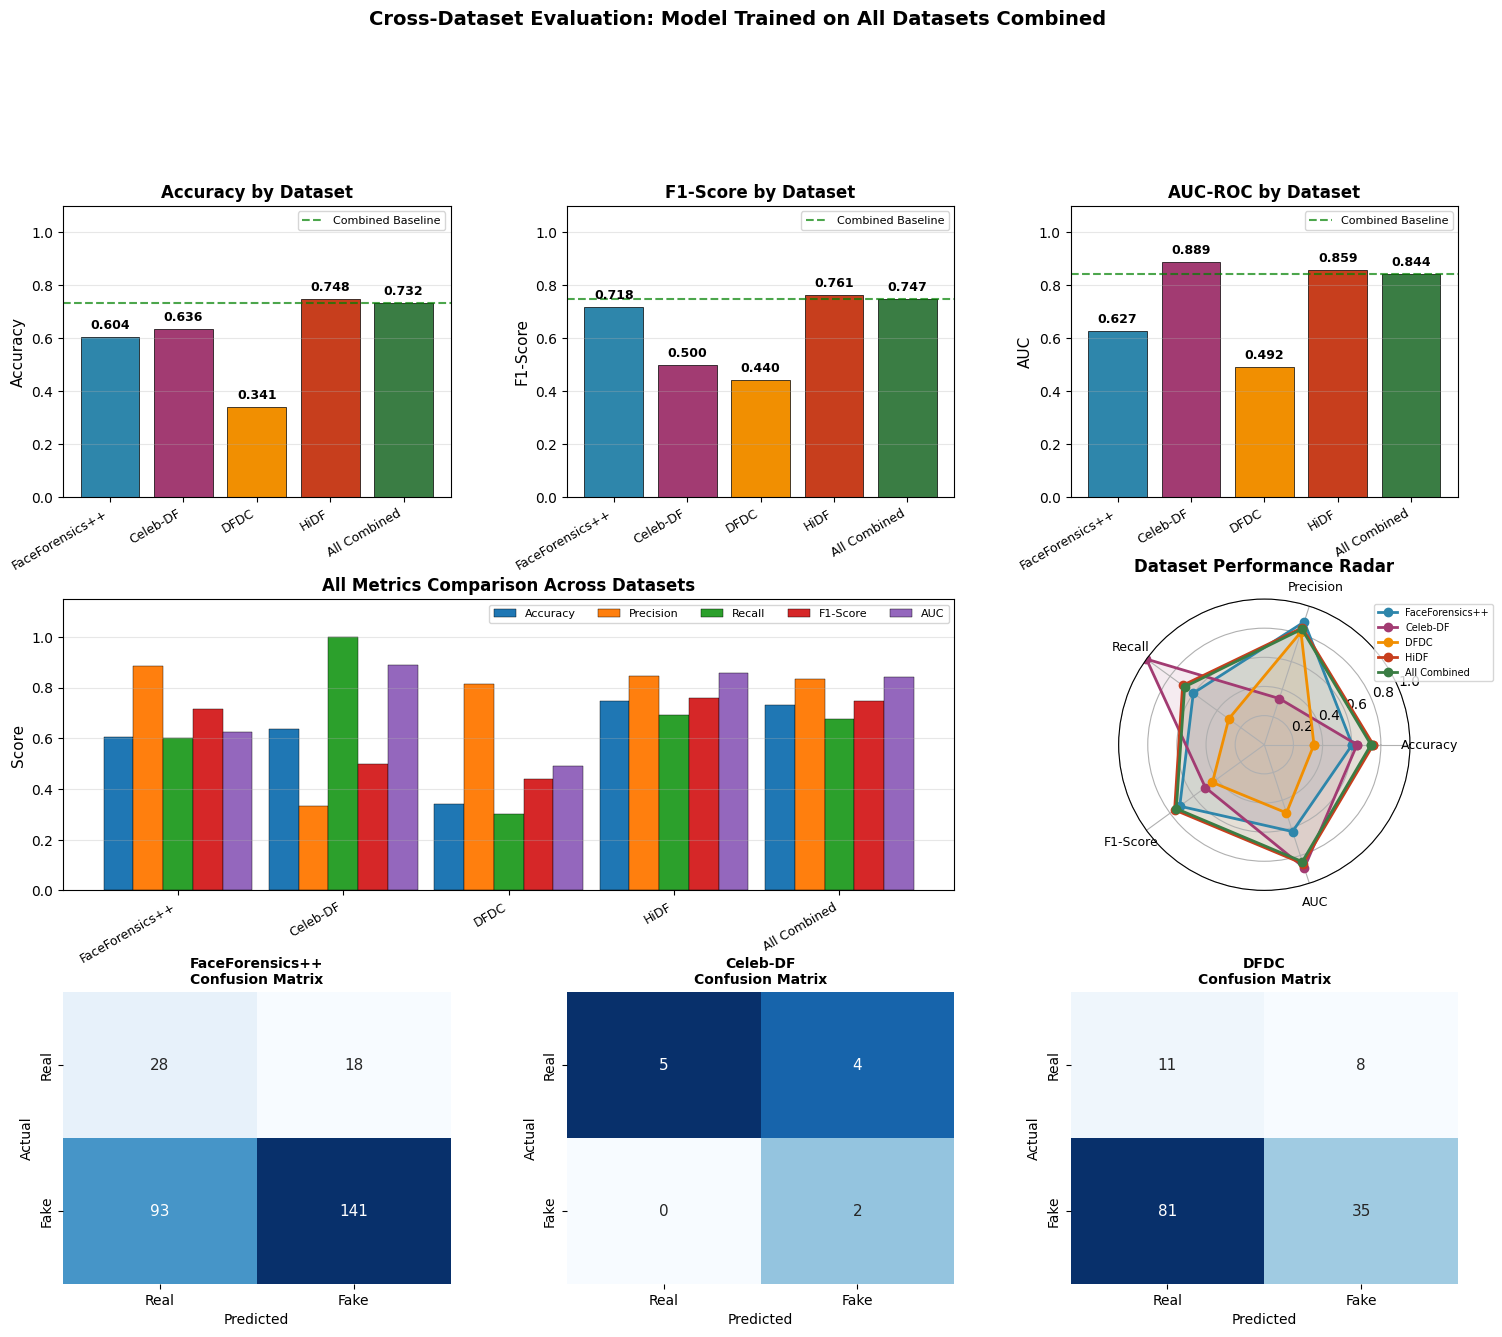


✓ Visualization saved to: E:\MMF Deepfake Detection\results\cross_dataset_evaluation.png


In [19]:
# ============================================================================
# CROSS-DATASET EVALUATION VISUALIZATION
# ============================================================================

if cross_eval_results:
    fig = plt.figure(figsize=(18, 14))
    
    # Create grid for subplots
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
    
    # Color palette for datasets
    dataset_colors = {
        'FaceForensics++': '#2E86AB',
        'Celeb-DF': '#A23B72', 
        'DFDC': '#F18F01',
        'HiDF': '#C73E1D',
        'All Combined': '#3A7D44'
    }
    colors = [dataset_colors.get(name, '#666666') for name in cross_eval_df['Dataset']]
    
    # =========================================================================
    # Plot 1: Accuracy Comparison (Top Left)
    # =========================================================================
    ax1 = fig.add_subplot(gs[0, 0])
    bars = ax1.bar(cross_eval_df['Dataset'], cross_eval_df['Accuracy'], color=colors, edgecolor='black', linewidth=0.5)
    ax1.set_ylabel('Accuracy', fontsize=11)
    ax1.set_title('Accuracy by Dataset', fontsize=12, fontweight='bold')
    ax1.set_ylim(0, 1.1)
    ax1.axhline(y=cross_eval_df[cross_eval_df['Dataset'] == 'All Combined']['Accuracy'].values[0], 
                color='green', linestyle='--', alpha=0.7, label='Combined Baseline')
    for bar, acc in zip(bars, cross_eval_df['Accuracy']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{acc:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=30, ha='right', fontsize=9)
    ax1.legend(fontsize=8)
    ax1.grid(axis='y', alpha=0.3)
    
    # =========================================================================
    # Plot 2: F1-Score Comparison (Top Middle)
    # =========================================================================
    ax2 = fig.add_subplot(gs[0, 1])
    bars = ax2.bar(cross_eval_df['Dataset'], cross_eval_df['F1-Score'], color=colors, edgecolor='black', linewidth=0.5)
    ax2.set_ylabel('F1-Score', fontsize=11)
    ax2.set_title('F1-Score by Dataset', fontsize=12, fontweight='bold')
    ax2.set_ylim(0, 1.1)
    ax2.axhline(y=cross_eval_df[cross_eval_df['Dataset'] == 'All Combined']['F1-Score'].values[0], 
                color='green', linestyle='--', alpha=0.7, label='Combined Baseline')
    for bar, f1 in zip(bars, cross_eval_df['F1-Score']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{f1:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=30, ha='right', fontsize=9)
    ax2.legend(fontsize=8)
    ax2.grid(axis='y', alpha=0.3)
    
    # =========================================================================
    # Plot 3: AUC Comparison (Top Right)
    # =========================================================================
    ax3 = fig.add_subplot(gs[0, 2])
    bars = ax3.bar(cross_eval_df['Dataset'], cross_eval_df['AUC'], color=colors, edgecolor='black', linewidth=0.5)
    ax3.set_ylabel('AUC', fontsize=11)
    ax3.set_title('AUC-ROC by Dataset', fontsize=12, fontweight='bold')
    ax3.set_ylim(0, 1.1)
    ax3.axhline(y=cross_eval_df[cross_eval_df['Dataset'] == 'All Combined']['AUC'].values[0], 
                color='green', linestyle='--', alpha=0.7, label='Combined Baseline')
    for bar, auc in zip(bars, cross_eval_df['AUC']):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{auc:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=30, ha='right', fontsize=9)
    ax3.legend(fontsize=8)
    ax3.grid(axis='y', alpha=0.3)
    
    # =========================================================================
    # Plot 4: All Metrics Grouped Bar Chart (Middle Left)
    # =========================================================================
    ax4 = fig.add_subplot(gs[1, 0:2])
    x = np.arange(len(cross_eval_df))
    width = 0.18
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
    metric_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for i, (metric, color) in enumerate(zip(metrics, metric_colors)):
        offset = (i - len(metrics)/2 + 0.5) * width
        bars = ax4.bar(x + offset, cross_eval_df[metric], width, label=metric, color=color, edgecolor='black', linewidth=0.3)
    
    ax4.set_ylabel('Score', fontsize=11)
    ax4.set_title('All Metrics Comparison Across Datasets', fontsize=12, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(cross_eval_df['Dataset'], rotation=30, ha='right', fontsize=9)
    ax4.legend(loc='upper right', fontsize=8, ncol=5)
    ax4.set_ylim(0, 1.15)
    ax4.grid(axis='y', alpha=0.3)
    
    # =========================================================================
    # Plot 5: Radar Chart for Dataset Comparison (Middle Right)
    # =========================================================================
    ax5 = fig.add_subplot(gs[1, 2], polar=True)
    
    categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the loop
    
    for idx, row in cross_eval_df.iterrows():
        values = [row[cat] for cat in categories]
        values += values[:1]  # Complete the loop
        color = dataset_colors.get(row['Dataset'], '#666666')
        ax5.plot(angles, values, 'o-', linewidth=2, label=row['Dataset'], color=color)
        ax5.fill(angles, values, alpha=0.1, color=color)
    
    ax5.set_xticks(angles[:-1])
    ax5.set_xticklabels(categories, fontsize=9)
    ax5.set_ylim(0, 1)
    ax5.set_title('Dataset Performance Radar', fontsize=12, fontweight='bold', pad=20)
    ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=7)
    
    # =========================================================================
    # Plot 6: Confusion Matrices (Bottom Row)
    # =========================================================================
    cm_datasets = ['FaceForensics++', 'Celeb-DF', 'DFDC', 'HiDF', 'All Combined']
    
    for i, dataset_name in enumerate(cm_datasets[:3]):  # First 3 in bottom row
        if dataset_name in cross_eval_results:
            ax_cm = fig.add_subplot(gs[2, i])
            cm = cross_eval_results[dataset_name]['confusion_matrix']
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm,
                       xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'],
                       cbar=False, annot_kws={'fontsize': 11})
            ax_cm.set_xlabel('Predicted', fontsize=10)
            ax_cm.set_ylabel('Actual', fontsize=10)
            ax_cm.set_title(f'{dataset_name}\nConfusion Matrix', fontsize=10, fontweight='bold')
    
    plt.suptitle('Cross-Dataset Evaluation: Model Trained on All Datasets Combined', 
                 fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.savefig(config.RESULTS_DIR / 'cross_dataset_evaluation.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Visualization saved to: {config.RESULTS_DIR / 'cross_dataset_evaluation.png'}")
else:
    print("⚠ No cross-dataset evaluation results to visualize.")

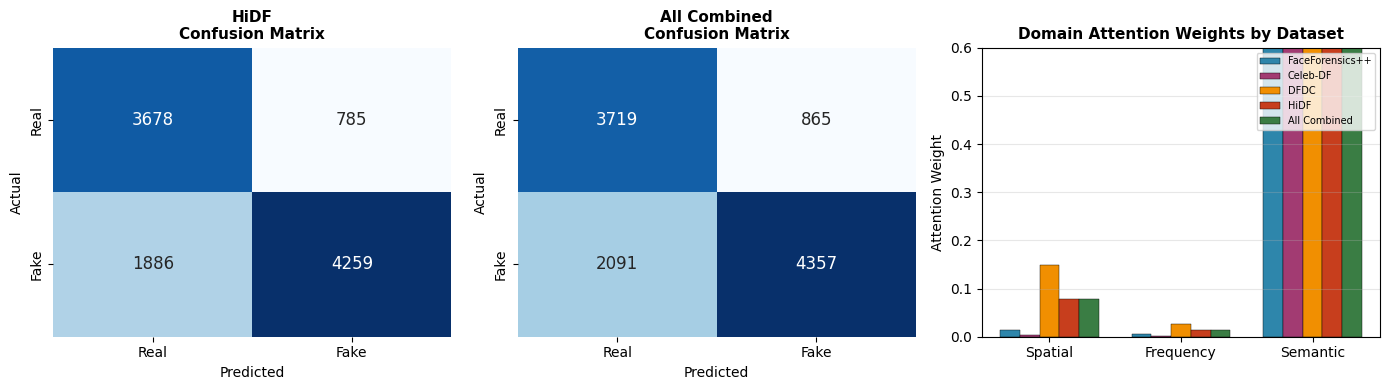

✓ Additional visualization saved to: E:\MMF Deepfake Detection\results\cross_dataset_additional.png

DOMAIN ATTENTION WEIGHTS ANALYSIS

Domain Attention Weights per Dataset:
        Dataset        Spatial     Frequency       Semantic
FaceForensics++  0.0142 (1.4%) 0.0049 (0.5%) 0.9809 (98.1%)
       Celeb-DF  0.0029 (0.3%) 0.0011 (0.1%) 0.9960 (99.6%)
           DFDC 0.1490 (14.9%) 0.0257 (2.6%) 0.8253 (82.5%)
           HiDF  0.0777 (7.8%) 0.0132 (1.3%) 0.9091 (90.9%)
   All Combined  0.0793 (7.9%) 0.0134 (1.3%) 0.9073 (90.7%)


In [20]:
# ============================================================================
# ADDITIONAL VISUALIZATIONS: Remaining Confusion Matrices & Domain Weights
# ============================================================================

if cross_eval_results:
    fig2, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    # =========================================================================
    # Plot remaining confusion matrices (HiDF and All Combined)
    # =========================================================================
    remaining_datasets = ['HiDF', 'All Combined']
    
    for i, dataset_name in enumerate(remaining_datasets):
        if dataset_name in cross_eval_results:
            cm = cross_eval_results[dataset_name]['confusion_matrix']
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                       xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'],
                       cbar=False, annot_kws={'fontsize': 12})
            axes[i].set_xlabel('Predicted', fontsize=10)
            axes[i].set_ylabel('Actual', fontsize=10)
            axes[i].set_title(f'{dataset_name}\nConfusion Matrix', fontsize=11, fontweight='bold')
    
    # =========================================================================
    # Plot Domain Attention Weights Comparison
    # =========================================================================
    ax_weights = axes[2]
    
    domain_labels = ['Spatial', 'Frequency', 'Semantic']
    x = np.arange(len(domain_labels))
    width = 0.15
    
    dataset_colors = {
        'FaceForensics++': '#2E86AB',
        'Celeb-DF': '#A23B72', 
        'DFDC': '#F18F01',
        'HiDF': '#C73E1D',
        'All Combined': '#3A7D44'
    }
    
    for i, (dataset_name, result) in enumerate(cross_eval_results.items()):
        if result['domain_weights'] is not None:
            weights = result['domain_weights']
            color = dataset_colors.get(dataset_name, '#666666')
            offset = (i - len(cross_eval_results)/2 + 0.5) * width
            ax_weights.bar(x + offset, weights, width, label=dataset_name, color=color, edgecolor='black', linewidth=0.3)
    
    ax_weights.set_ylabel('Attention Weight', fontsize=10)
    ax_weights.set_title('Domain Attention Weights by Dataset', fontsize=11, fontweight='bold')
    ax_weights.set_xticks(x)
    ax_weights.set_xticklabels(domain_labels, fontsize=10)
    ax_weights.legend(loc='upper right', fontsize=7)
    ax_weights.set_ylim(0, 0.6)
    ax_weights.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(config.RESULTS_DIR / 'cross_dataset_additional.png', dpi=150)
    plt.show()
    
    print(f"✓ Additional visualization saved to: {config.RESULTS_DIR / 'cross_dataset_additional.png'}")

# ============================================================================
# DOMAIN ATTENTION WEIGHTS SUMMARY TABLE
# ============================================================================

print(f"\n{'='*70}")
print("DOMAIN ATTENTION WEIGHTS ANALYSIS")
print(f"{'='*70}")

domain_labels = ['Spatial', 'Frequency', 'Semantic']

if cross_eval_results:
    weights_data = []
    for name, result in cross_eval_results.items():
        if result['domain_weights'] is not None:
            weights = result['domain_weights']
            weights_data.append({
                'Dataset': name,
                'Spatial': f"{weights[0]:.4f} ({weights[0]*100:.1f}%)",
                'Frequency': f"{weights[1]:.4f} ({weights[1]*100:.1f}%)",
                'Semantic': f"{weights[2]:.4f} ({weights[2]*100:.1f}%)"
            })
    
    if weights_data:
        weights_df = pd.DataFrame(weights_data)
        print("\nDomain Attention Weights per Dataset:")
        print(weights_df.to_string(index=False))

## Section 12: Performance Analysis & Insights

In [21]:
# ============================================================================
# PERFORMANCE ANALYSIS & INSIGHTS
# ============================================================================

print(f"\n{'='*70}")
print("CROSS-DATASET PERFORMANCE ANALYSIS")
print(f"{'='*70}")

if cross_eval_results and len(cross_eval_results) > 1:
    # Get 'All Combined' baseline
    combined_acc = cross_eval_results.get('All Combined', {}).get('accuracy', 0)
    combined_f1 = cross_eval_results.get('All Combined', {}).get('f1', 0)
    
    print("\n📊 GENERALIZATION ANALYSIS:")
    print(f"\nBaseline (All Combined): Accuracy={combined_acc:.4f}, F1={combined_f1:.4f}")
    print("\nPerformance relative to combined baseline:")
    print("-" * 50)
    
    for dataset_name, result in cross_eval_results.items():
        if dataset_name == 'All Combined':
            continue
        
        acc_diff = result['accuracy'] - combined_acc
        f1_diff = result['f1'] - combined_f1
        
        acc_symbol = "↑" if acc_diff >= 0 else "↓"
        f1_symbol = "↑" if f1_diff >= 0 else "↓"
        
        print(f"\n{dataset_name}:")
        print(f"  Accuracy: {result['accuracy']:.4f} ({acc_symbol} {abs(acc_diff)*100:.2f}%)")
        print(f"  F1-Score: {result['f1']:.4f} ({f1_symbol} {abs(f1_diff)*100:.2f}%)")
        
        # Classify performance
        if result['accuracy'] >= combined_acc:
            print(f"  Status: ✓ Generalizes WELL to this dataset")
        elif result['accuracy'] >= combined_acc - 0.1:
            print(f"  Status: ~ Moderate generalization drop")
        else:
            print(f"  Status: ⚠ Significant generalization gap")
    
    # Find best and worst performing datasets
    individual_results = {k: v for k, v in cross_eval_results.items() if k != 'All Combined'}
    
    if individual_results:
        best_dataset = max(individual_results.items(), key=lambda x: x[1]['f1'])
        worst_dataset = min(individual_results.items(), key=lambda x: x[1]['f1'])
        
        print(f"\n{'='*70}")
        print("KEY FINDINGS:")
        print(f"{'='*70}")
        print(f"\n✓ Best Generalization: {best_dataset[0]}")
        print(f"  F1-Score: {best_dataset[1]['f1']:.4f}, Accuracy: {best_dataset[1]['accuracy']:.4f}")
        
        print(f"\n⚠ Most Challenging: {worst_dataset[0]}")
        print(f"  F1-Score: {worst_dataset[1]['f1']:.4f}, Accuracy: {worst_dataset[1]['accuracy']:.4f}")
        
        # Calculate average performance
        avg_acc = np.mean([r['accuracy'] for r in individual_results.values()])
        avg_f1 = np.mean([r['f1'] for r in individual_results.values()])
        std_acc = np.std([r['accuracy'] for r in individual_results.values()])
        std_f1 = np.std([r['f1'] for r in individual_results.values()])
        
        print(f"\n📈 OVERALL STATISTICS:")
        print(f"  Average Accuracy: {avg_acc:.4f} (±{std_acc:.4f})")
        print(f"  Average F1-Score: {avg_f1:.4f} (±{std_f1:.4f})")
        
        # Consistency check
        if std_f1 < 0.1:
            print(f"\n  Consistency: ✓ Model performs consistently across datasets (low variance)")
        elif std_f1 < 0.2:
            print(f"\n  Consistency: ~ Moderate variance in cross-dataset performance")
        else:
            print(f"\n  Consistency: ⚠ High variance - model may be biased towards certain datasets")
else:
    print("⚠ Insufficient results for cross-dataset analysis")


CROSS-DATASET PERFORMANCE ANALYSIS

📊 GENERALIZATION ANALYSIS:

Baseline (All Combined): Accuracy=0.7321, F1=0.7467

Performance relative to combined baseline:
--------------------------------------------------

FaceForensics++:
  Accuracy: 0.6036 (↓ 12.85%)
  F1-Score: 0.7176 (↓ 2.91%)
  Status: ⚠ Significant generalization gap

Celeb-DF:
  Accuracy: 0.6364 (↓ 9.57%)
  F1-Score: 0.5000 (↓ 24.67%)
  Status: ~ Moderate generalization drop

DFDC:
  Accuracy: 0.3407 (↓ 39.13%)
  F1-Score: 0.4403 (↓ 30.64%)
  Status: ⚠ Significant generalization gap

HiDF:
  Accuracy: 0.7482 (↑ 1.62%)
  F1-Score: 0.7613 (↑ 1.46%)
  Status: ✓ Generalizes WELL to this dataset

KEY FINDINGS:

✓ Best Generalization: HiDF
  F1-Score: 0.7613, Accuracy: 0.7482

⚠ Most Challenging: DFDC
  F1-Score: 0.4403, Accuracy: 0.3407

📈 OVERALL STATISTICS:
  Average Accuracy: 0.5822 (±0.1494)
  Average F1-Score: 0.6048 (±0.1372)

  Consistency: ~ Moderate variance in cross-dataset performance


## Section 13: Final Summary

In [22]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print(f"\n{'#'*70}")
print("# INTEGRATED TRAINING COMPLETE - FINAL SUMMARY")
print(f"{'#'*70}")

print(f"\n📊 Configuration:")
print(f"  - Model: Complete Attention Model (3-Domain)")
print(f"  - Data Percentages:")
print(f"      FaceForensics++: {config.FFPP_PERCENTAGE * 100:.1f}%")
print(f"      Celeb-DF: {config.CELEBDF_PERCENTAGE * 100:.1f}%")
print(f"      DFDC: {config.DFDC_PERCENTAGE * 100:.1f}%")
print(f"      HiDF: {config.HIDF_PERCENTAGE * 100:.1f}%")
print(f"  - Feature Dimensions: Spatial({config.SPATIAL_DIM}), Freq({config.FREQ_DIM}), Semantic({config.SEMANTIC_DIM})")

print(f"\n📈 Training Results:")
if result_all and 'metrics' in result_all:
    metrics = result_all['metrics']
    print(f"  - Training Accuracy: {metrics.get('accuracy', 0):.4f}")
    print(f"  - Training F1-Score: {metrics.get('f1', 0):.4f}")
    print(f"  - Training AUC: {metrics.get('auc', 0):.4f}")

print(f"\n🔬 Cross-Dataset Evaluation:")
if cross_eval_results:
    for name, result in cross_eval_results.items():
        print(f"  - {name}: Acc={result['accuracy']:.4f}, F1={result['f1']:.4f}")

print(f"\n📁 Saved Files:")
print(f"  - Metadata: {config.INTEGRATED_METADATA_PATH}")
print(f"  - Cross-Dataset Results: {config.RESULTS_DIR / 'cross_dataset_evaluation.csv'}")
print(f"  - Visualizations: {config.RESULTS_DIR / 'cross_dataset_evaluation.png'}")
print(f"  - Model Checkpoint: {config.CHECKPOINTS_DIR / 'complete_attention_all_datasets_best.pth'}")

# Save final results as JSON
final_results = {
    'config': {
        'ffpp_percentage': config.FFPP_PERCENTAGE,
        'celebdf_percentage': config.CELEBDF_PERCENTAGE,
        'dfdc_percentage': config.DFDC_PERCENTAGE,
        'hidf_percentage': config.HIDF_PERCENTAGE,
        'model_type': 'CompleteAttentionModel',
        'epochs': config.EPOCHS,
        'batch_size': config.BATCH_SIZE
    },
    'training_metrics': result_all['metrics'] if result_all else {},
    'cross_dataset_evaluation': {
        name: {k: v for k, v in result.items() if k not in ['confusion_matrix', 'predictions', 'labels', 'probabilities', 'domain_weights']}
        for name, result in cross_eval_results.items()
    } if cross_eval_results else {}
}

with open(config.RESULTS_DIR / 'final_results.json', 'w') as f:
    json.dump(final_results, f, indent=2, default=str)

print(f"  - Final Results JSON: {config.RESULTS_DIR / 'final_results.json'}")

print(f"\n{'#'*70}")
print("# TRAINING PIPELINE COMPLETE")
print(f"{'#'*70}")


######################################################################
# INTEGRATED TRAINING COMPLETE - FINAL SUMMARY
######################################################################

📊 Configuration:
  - Model: Complete Attention Model (3-Domain)
  - Data Percentages:
      FaceForensics++: 10.0%
      Celeb-DF: 5.0%
      DFDC: 30.0%
      HiDF: 50.0%
  - Feature Dimensions: Spatial(2048), Freq(4), Semantic(768)

📈 Training Results:
  - Training Accuracy: 0.7241
  - Training F1-Score: 0.7578
  - Training AUC: 0.8440

🔬 Cross-Dataset Evaluation:
  - FaceForensics++: Acc=0.6036, F1=0.7176
  - Celeb-DF: Acc=0.6364, F1=0.5000
  - DFDC: Acc=0.3407, F1=0.4403
  - HiDF: Acc=0.7482, F1=0.7613
  - All Combined: Acc=0.7321, F1=0.7467

📁 Saved Files:
  - Metadata: E:\MMF Deepfake Detection\integrated_metadata.csv
  - Cross-Dataset Results: E:\MMF Deepfake Detection\results\cross_dataset_evaluation.csv
  - Visualizations: E:\MMF Deepfake Detection\results\cross_dataset_evaluation.png
  - 